<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/4.%20Measurement%20Induced%20Dephasing%20Practice%20fail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 33.8 MB/s eta 0:00:00


In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from numpy.random import uniform

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


# 9. Measurement Induced Dephasing

###1) Hamiltonian & Function Setting

Lab Frame

$H_0 = -\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + g\sigma_x(a+a^\dagger)$

$H_1 = A(t) (\hat{a} + \hat{a}^\dagger) \cos{(\omega_{r,d} t)}$

$H_2 = B(t) \sigma_x \cos{(\omega_{r,d} t)}$

Rotating Frame

$H_0 = -\frac{\omega_q-\omega_{rd}}{2}\sigma_z + ({\omega_r-\omega_{rd}})a^\dagger a + \chi\sigma_z(a^\dagger a)$

$H_1 = \frac{A(t)}{2} (\hat{a} + \hat{a}^\dagger) $

$H_2 = \frac{B(t)}{2}  \sigma_x $

In [376]:
# operator
N = 20

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.1   # external coupling rate of resonator in units of GHz

In [377]:
sz = sigmaz()
sx = sigmax()
sy = sigmay()

sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)

In [378]:
sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [379]:
H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())

H1 = 0.5*tensor(qeye(2), a + a.dag())

H2_x = 0.5*sx_composite

In [380]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-1.25) * (t < T_cent+1.25)

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-1.25) * (t < T_cent+1.25)

In [381]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

In [382]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [383]:
# time-dependent envelope for drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_qubit_rotating_frame_x(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = f(t, {'A': A}, T_srt)

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(t, {'A': A}, T_cent)

    f = Hrd_env(Env, 0)
    pulse = pulse + f(t, {'A': A}, T_end)

    return pulse

In [384]:
# time-dependent coefficient for drive
def Hrd_res_env(t, args):
    """
    Envelope function for the readout drive
    """
    A_res = args['A_res'] # amplitude of the readout drive
    T_res = args['T_res'] # duration of the readout drive, in units of ns

    return (A_res/2) * (0 <= t) * (t <= T_res)

def Hrd_res_coeff(t, args):
    omega_rd = args['omega_rd']
    return 2*Hrd_res_env(t, args) * np.cos(omega_rd * t)

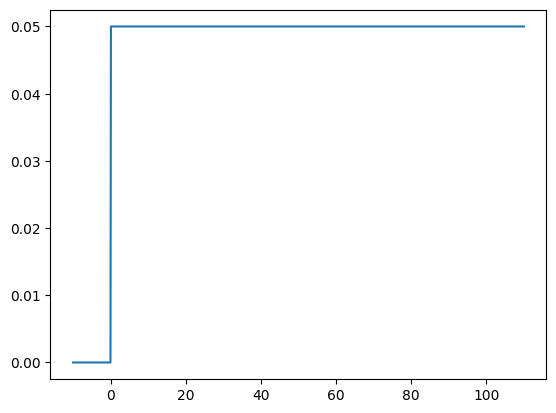

In [385]:
# resonator pulse simulation (rotating frame)
tlist = np.linspace(-10, 110, 1000)
plt.figure()
plt.plot(tlist, Hrd_res_env(tlist, {'A_res': 0.1, 'T_res': 150, 'omega_rd': omega_rd}))

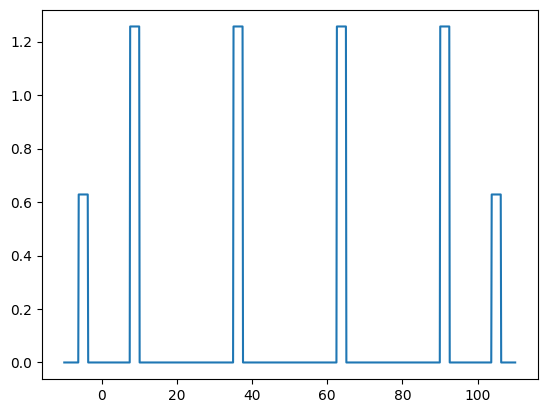

In [386]:
# qubit pulse simulation (rotating frame)
tlist = np.linspace(-10, 110, 1000)
plt.figure()
plt.plot(tlist, Hrd_qubit_rotating_frame_x(tlist, {'A': 2*np.pi*0.2, 'omega_rd': omega_rd, 'T_srt': -5, 'T_end': 105, 'N': 4, 'Env': 0, 'Func': 0}))

### 2) Test Simulation (Ramsey, Rotating Frame)

Driving Amplitude $A=1GHz$, $A=0.1GHz$, $A=0.01GHz$

Driving Frequency $\omega_{rd}=6.998GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$


In [260]:
# operator
N = 60

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [261]:
omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.998  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

result0 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result1 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result2 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.01, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

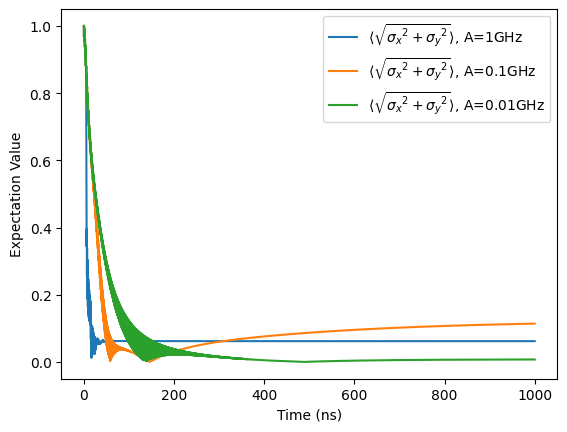

In [262]:
# Plot sqrt(X**2+Y**2)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result0.expect[0])**2 + (result0.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=1GHz')
ax.plot(tlist, np.sqrt((result1.expect[0])**2 + (result1.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.1GHz')
ax.plot(tlist, np.sqrt((result2.expect[0])**2 + (result2.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.01GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

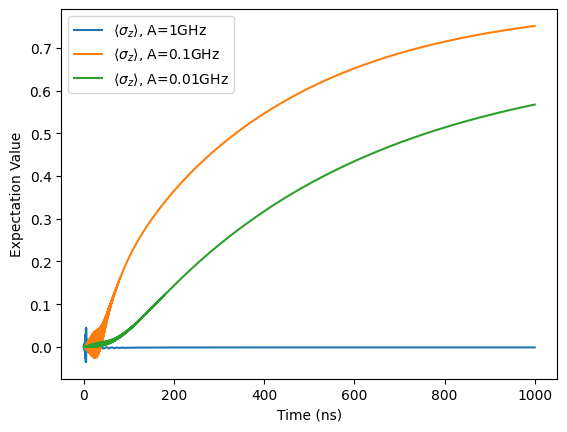

In [263]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$, A=1GHz')
ax.plot(tlist, result1.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.1GHz')
ax.plot(tlist, result2.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.01GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

A=1GHz


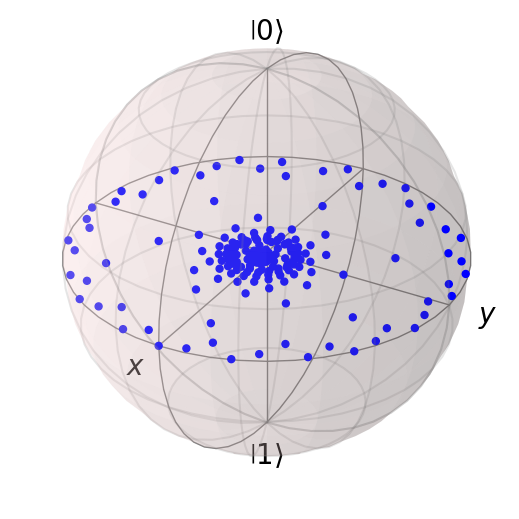

In [264]:
# Create Bloch sphere plot
print("A=1GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

A=0.1GHz


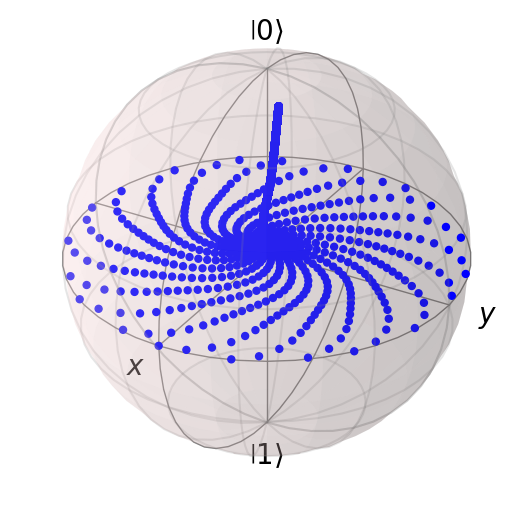

In [265]:
# Create Bloch sphere plot
sphere = Bloch()
print("A=0.1GHz")
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result1.expect, meth="s")
sphere.show()

A=0.01GHz


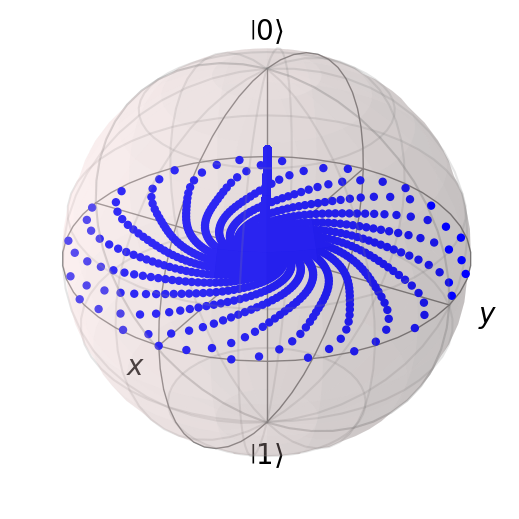

In [266]:
# Create Bloch sphere plot
print("A=0.01GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result2.expect, meth="s")
sphere.show()

Text(0, 0.5, 'Photon Number Expectation Value')

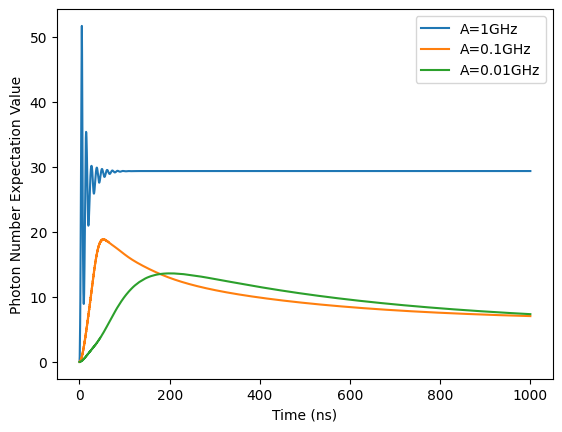

In [267]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[7], label = 'A=1GHz')
ax.plot(tlist, result1.expect[7], label = 'A=0.1GHz')
ax.plot(tlist, result2.expect[7], label = 'A=0.01GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

### 3) Test Simulation (Ramsey, Rotating Frame)

Driving Amplitude $A=1GHz$, $A=0.1GHz$, $A=0.01GHz$

Driving Frequency $\omega_{rd}=6.99GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$


In [ ]:
# operator
N = 60

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [ ]:
omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.99   # qubit frequency in units of GHz
g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

result3 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result4 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result5 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.01, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

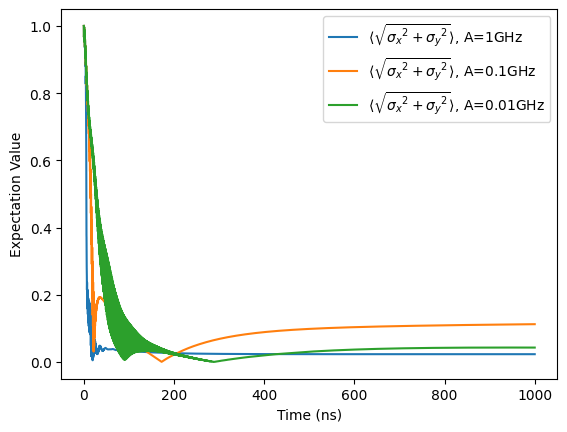

In [ ]:
# Plot sqrt(X**2+Y**2)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result3.expect[0])**2 + (result3.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=1GHz')
ax.plot(tlist, np.sqrt((result4.expect[0])**2 + (result4.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.1GHz')
ax.plot(tlist, np.sqrt((result5.expect[0])**2 + (result5.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.01GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

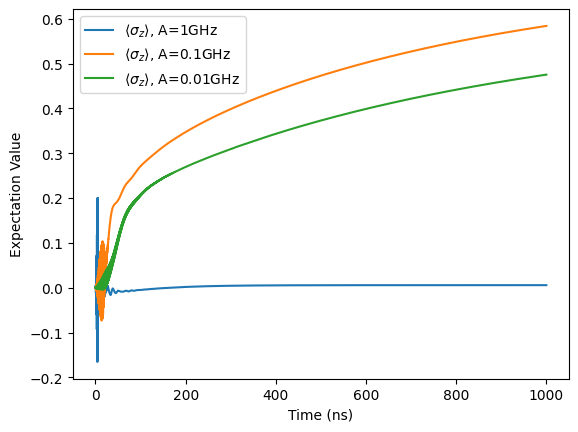

In [ ]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result3.expect[2], label = r'$\langle\sigma_z\rangle$, A=1GHz')
ax.plot(tlist, result4.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.1GHz')
ax.plot(tlist, result5.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.01GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

A=1GHz


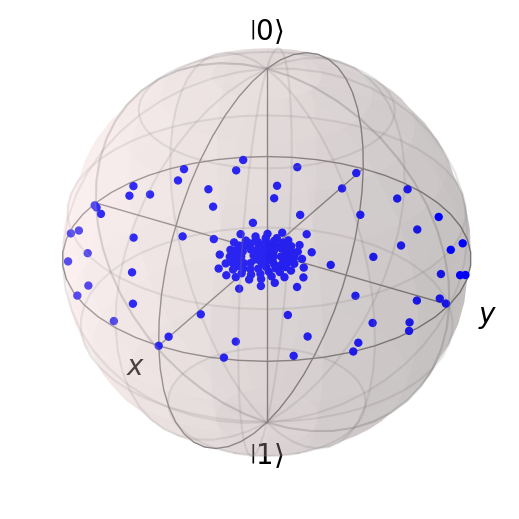

In [ ]:
# Create Bloch sphere plot
print("A=1GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result3.expect, meth="s")
sphere.show()

A=0.1GHz


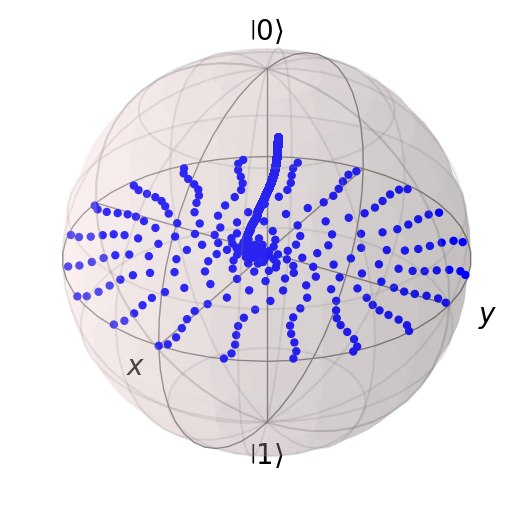

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
print("A=0.1GHz")
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result4.expect, meth="s")
sphere.show()

A=0.01GHz


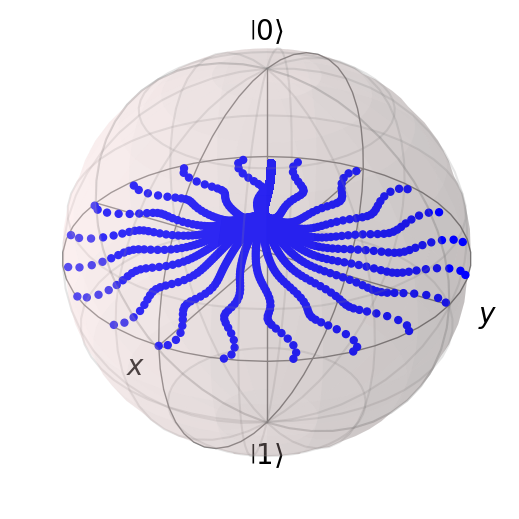

In [ ]:
# Create Bloch sphere plot
print("A=0.01GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result5.expect, meth="s")
sphere.show()

Text(0, 0.5, 'Photon Number Expectation Value')

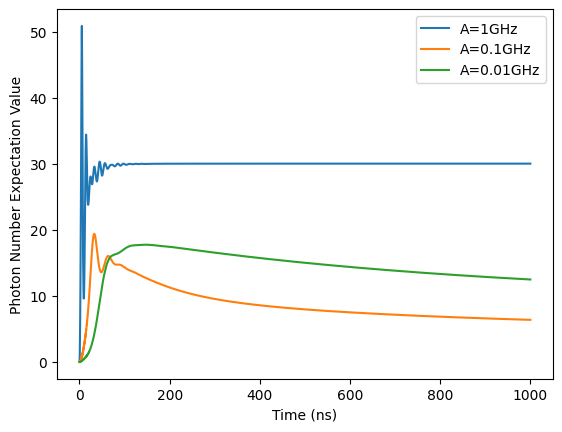

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result3.expect[7], label = 'A=1GHz')
ax.plot(tlist, result4.expect[7], label = 'A=0.1GHz')
ax.plot(tlist, result5.expect[7], label = 'A=0.01GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

### 4) Test Simulation (Ramsey, Rotating Frame, Truncate Number N=60)

Driving Amplitude $A=10GHz$, $A=3GHz$, $A=1GHz$, $A=0.1GHz$, $A=0.01GHz$, $A=0.001GHz$

Driving Frequency $\omega_{rd}=6.999GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$


In [276]:
# operator
N = 60

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [277]:
omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.999  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

result6 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result7 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result8 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.01, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result9 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

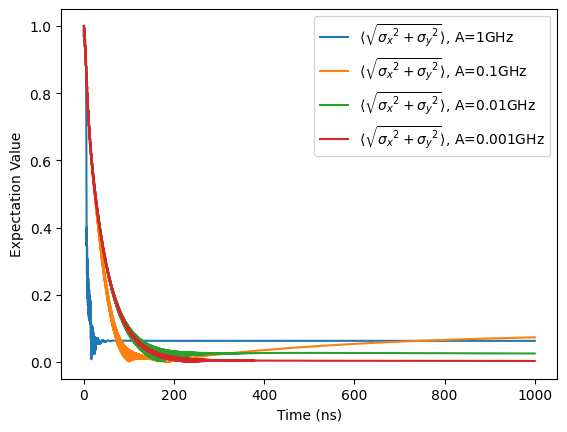

In [278]:
# Plot sqrt(X**2+Y**2)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result6.expect[0])**2 + (result6.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=1GHz')
ax.plot(tlist, np.sqrt((result7.expect[0])**2 + (result7.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.1GHz')
ax.plot(tlist, np.sqrt((result8.expect[0])**2 + (result8.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.01GHz')
ax.plot(tlist, np.sqrt((result9.expect[0])**2 + (result9.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

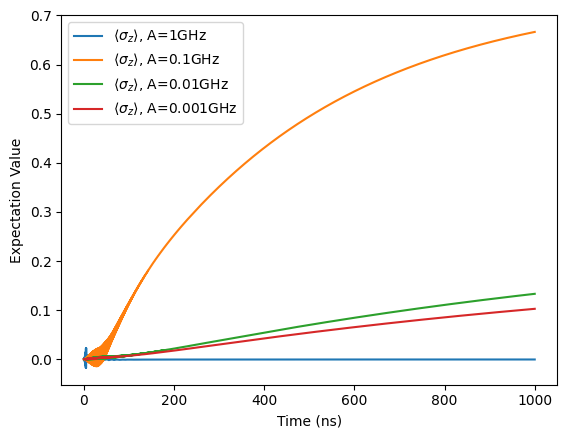

In [279]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result6.expect[2], label = r'$\langle\sigma_z\rangle$, A=1GHz')
ax.plot(tlist, result7.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.1GHz')
ax.plot(tlist, result8.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.01GHz')
ax.plot(tlist, result9.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.001GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

A=1GHz


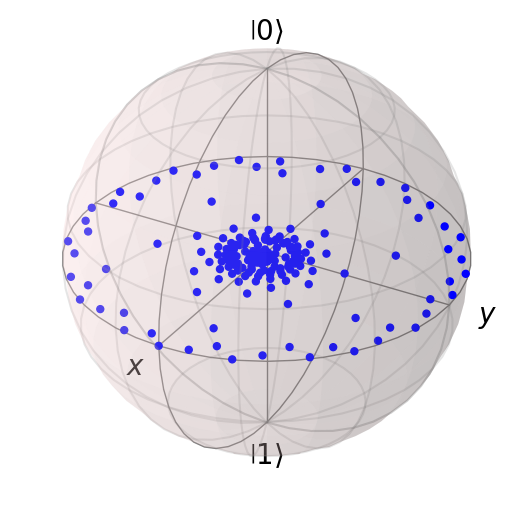

In [280]:
# Create Bloch sphere plot
print("A=1GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result6.expect, meth="s")
sphere.show()

A=0.1GHz


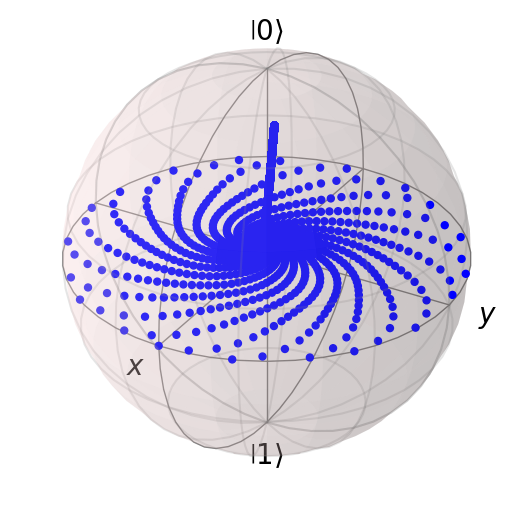

In [281]:
# Create Bloch sphere plot
print("A=0.1GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result7.expect, meth="s")
sphere.show()

A=0.01GHz


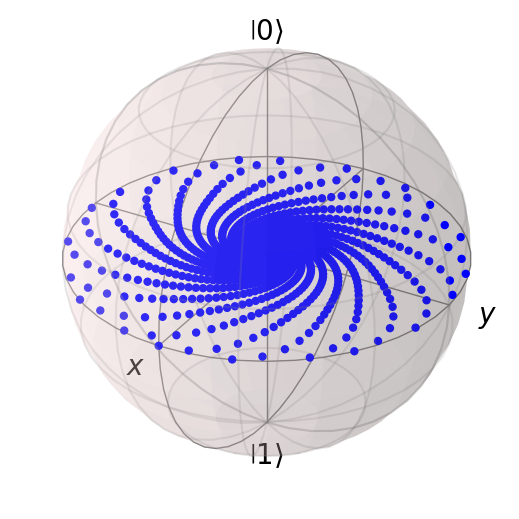

In [282]:
# Create Bloch sphere plot
print("A=0.01GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result8.expect, meth="s")
sphere.show()

A=0.001GHz


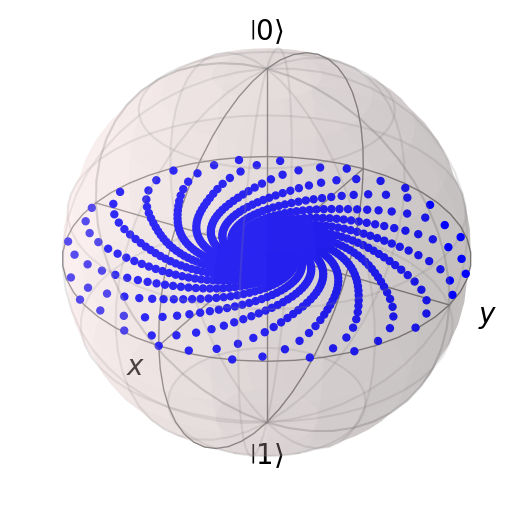

In [283]:
# Create Bloch sphere plot
print("A=0.001GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result9.expect, meth="s")
sphere.show()

Text(0, 0.5, 'Photon Number Expectation Value')

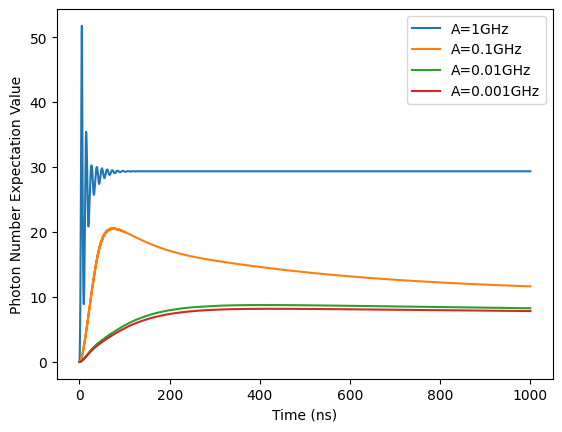

In [284]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result6.expect[7], label = 'A=1GHz')
ax.plot(tlist, result7.expect[7], label = 'A=0.1GHz')
ax.plot(tlist, result8.expect[7], label = 'A=0.01GHz')
ax.plot(tlist, result9.expect[7], label = 'A=0.001GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

### 5) Simulation with Qubit Longitudinal & Transverse Relaxation (Ramsey, Rotating Frame)

Driving Amplitude $A=0.001GHz$

Driving Frequency $\omega_{rd}=6.999GHz$

$\Gamma_{1}=0.2MHz$, $\Gamma_{2}=0.15MHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$


In [285]:
# operator
N = 60

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [286]:
omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.999  # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

gamma_1 = 2 * np.pi * 0.0002  # qubit longitudinal relaxation rate
gamma_2 = 2 * np.pi * 0.00015 # qubit transverse relaxation rate

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

result10 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a), np.sqrt(gamma_1) * sm_composite, np.sqrt(gamma_2/2) * sz_composite],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

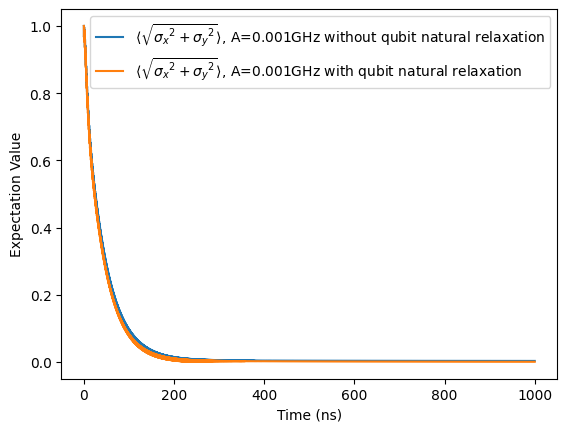

In [287]:
# Plot sqrt(X**2+Y**2)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result9.expect[0])**2 + (result9.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz without qubit natural relaxation')
ax.plot(tlist, np.sqrt((result10.expect[0])**2 + (result10.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz with qubit natural relaxation')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

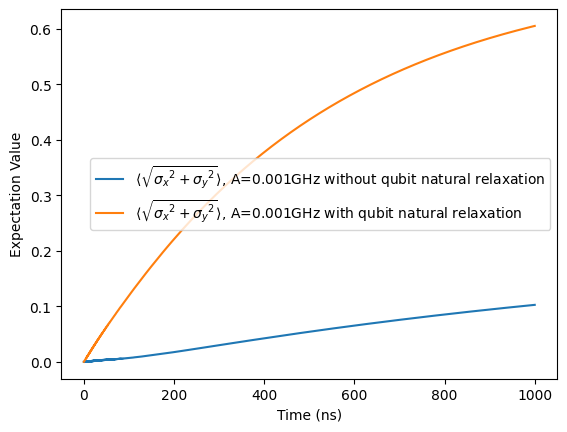

In [288]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result9.expect[2], label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz without qubit natural relaxation')
ax.plot(tlist, result10.expect[2], label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz with qubit natural relaxation')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

A=0.001GHz without qubit natural relaxation


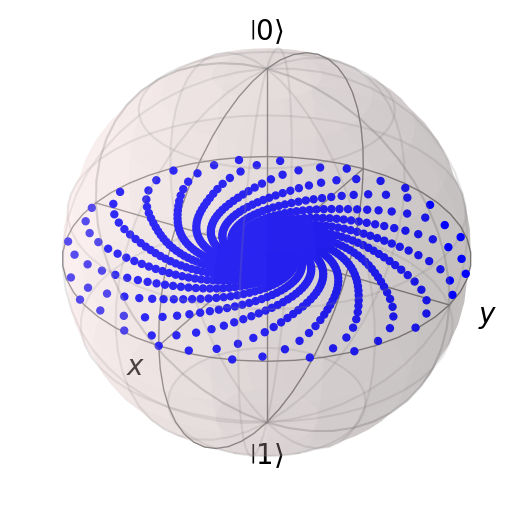

In [289]:
# Create Bloch sphere plot
print("A=0.001GHz without qubit natural relaxation")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result9.expect, meth="s")
sphere.show()

A=0.001GHz with qubit natural relaxation


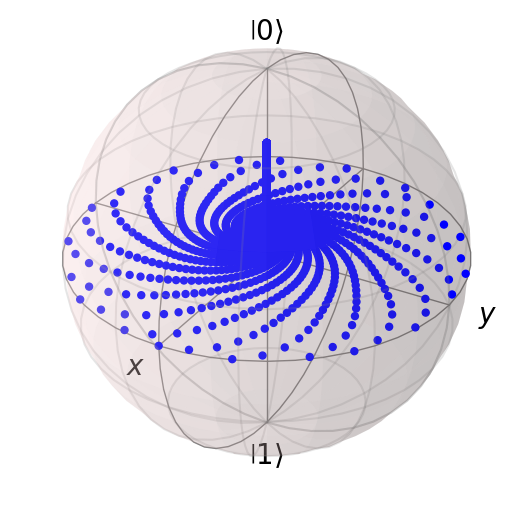

In [290]:
# Create Bloch sphere plot
print("A=0.001GHz with qubit natural relaxation")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result10.expect, meth="s")
sphere.show()

Text(0, 0.5, 'Photon Number Expectation Value')

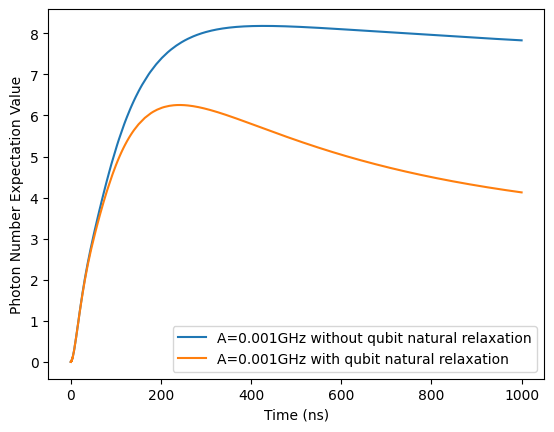

In [291]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result9.expect[7], label = 'A=0.001GHz without qubit natural relaxation')
ax.plot(tlist, result10.expect[7], label = 'A=0.001GHz with qubit natural relaxation')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

### 6) Test Simulation (Ramsey, Rotating Frame, Truncate Number N=80)

Driving Amplitude $A=10GHz$, $A=3GHz$, $A=1GHz$, $A=0.1GHz$, $A=0.01GHz$, $A=0.001GHz$

Driving Frequency $\omega_{rd}=6.999GHz$

$\Gamma_{1}=0.2MHz$, $\Gamma_{2}=0.15MHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$


In [295]:
# operator
N = 80

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [296]:
omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.999  # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

gamma_1 = 2 * np.pi * 0.0002  # qubit longitudinal relaxation rate
gamma_2 = 2 * np.pi * 0.00015 # qubit transverse relaxation rate

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

result11 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result12 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result13 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.01, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result14 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result15 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a), np.sqrt(gamma_1) * sm_composite, np.sqrt(gamma_2/2) * sz_composite],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

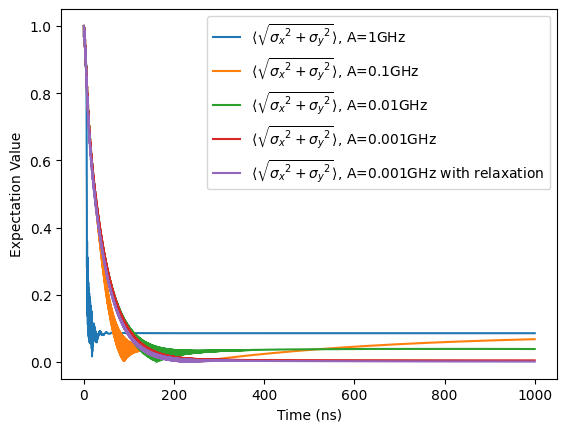

In [297]:
# Plot sqrt(X**2+Y**2)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result11.expect[0])**2 + (result11.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=1GHz')
ax.plot(tlist, np.sqrt((result12.expect[0])**2 + (result12.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.1GHz')
ax.plot(tlist, np.sqrt((result13.expect[0])**2 + (result13.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.01GHz')
ax.plot(tlist, np.sqrt((result14.expect[0])**2 + (result14.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz')
ax.plot(tlist, np.sqrt((result15.expect[0])**2 + (result15.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz with relaxation')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

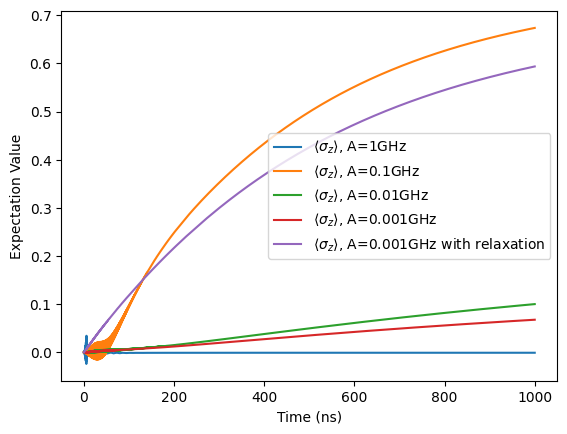

In [298]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result11.expect[2], label = r'$\langle\sigma_z\rangle$, A=1GHz')
ax.plot(tlist, result12.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.1GHz')
ax.plot(tlist, result13.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.01GHz')
ax.plot(tlist, result14.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.001GHz')
ax.plot(tlist, result15.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.001GHz with relaxation')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

A=1GHz


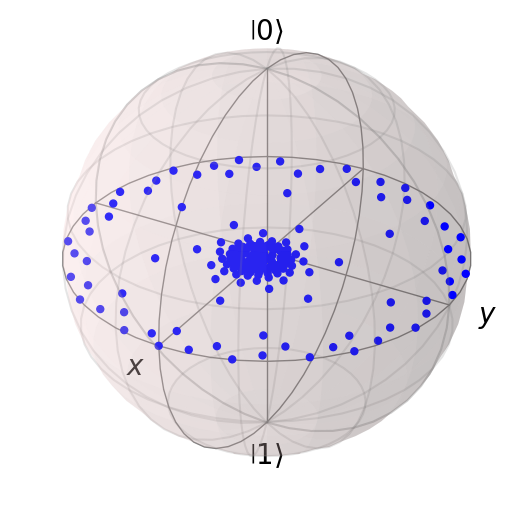

In [299]:
# Create Bloch sphere plot
print("A=1GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result11.expect, meth="s")
sphere.show()

A=0.1GHz


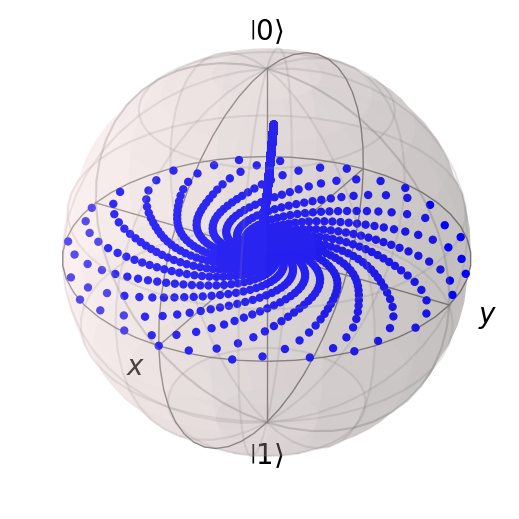

In [300]:
# Create Bloch sphere plot
print("A=0.1GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result12.expect, meth="s")
sphere.show()

A=0.01GHz


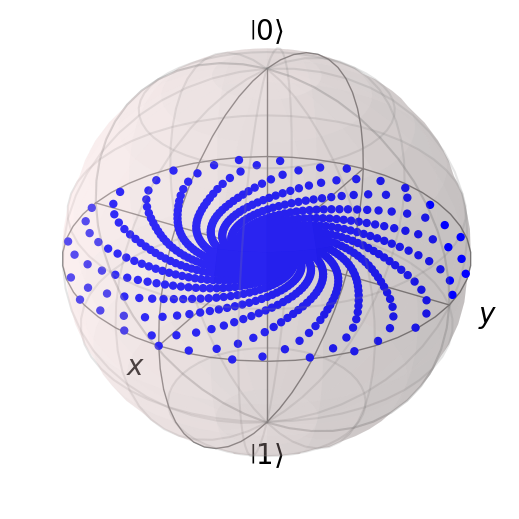

In [301]:
# Create Bloch sphere plot
print("A=0.01GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result13.expect, meth="s")
sphere.show()

A=0.001GHz


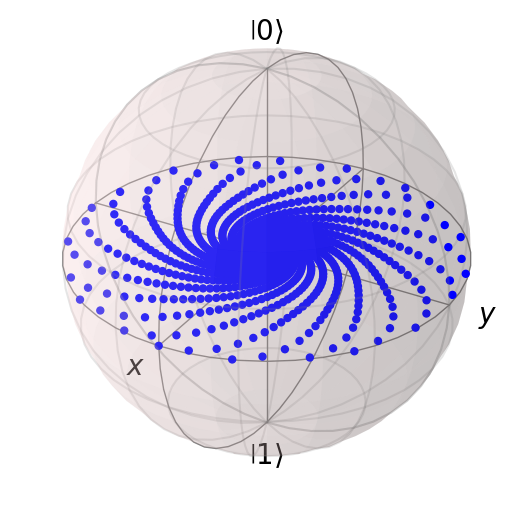

In [302]:
# Create Bloch sphere plot
print("A=0.001GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result14.expect, meth="s")
sphere.show()

A=0.001GHz with relaxation


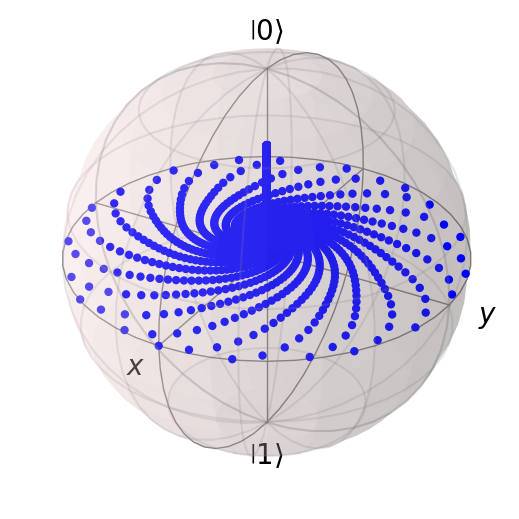

In [303]:
# Create Bloch sphere plot
print("A=0.001GHz with relaxation")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result15.expect, meth="s")
sphere.show()

Text(0, 0.5, 'Photon Number Expectation Value')

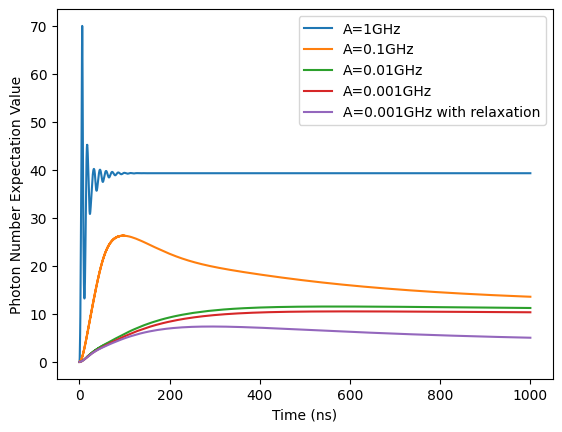

In [304]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result11.expect[7], label = 'A=1GHz')
ax.plot(tlist, result12.expect[7], label = 'A=0.1GHz')
ax.plot(tlist, result13.expect[7], label = 'A=0.01GHz')
ax.plot(tlist, result14.expect[7], label = 'A=0.001GHz')
ax.plot(tlist, result15.expect[7], label = 'A=0.001GHz with relaxation')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

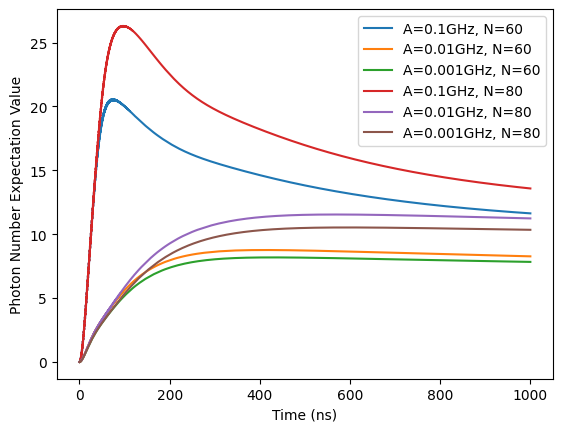

In [306]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result7.expect[7], label = 'A=0.1GHz, N=60')
ax.plot(tlist, result8.expect[7], label = 'A=0.01GHz, N=60')
ax.plot(tlist, result9.expect[7], label = 'A=0.001GHz, N=60')
ax.plot(tlist, result12.expect[7], label = 'A=0.1GHz, N=80')
ax.plot(tlist, result13.expect[7], label = 'A=0.01GHz, N=80')
ax.plot(tlist, result14.expect[7], label = 'A=0.001GHz, N=80')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

### 7) Test Simulation (Ramsey, Rotating Frame, Truncate Number N=100)

Driving Amplitude $A=10GHz$, $A=3GHz$, $A=1GHz$, $A=0.1GHz$, $A=0.01GHz$, $A=0.001GHz$

Driving Frequency $\omega_{rd}=6.999GHz$

$\Gamma_{1}=0.2MHz$, $\Gamma_{2}=0.15MHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$


In [307]:
# operator
N = 100

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [308]:
omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.999  # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

gamma_1 = 2 * np.pi * 0.0002  # qubit longitudinal relaxation rate
gamma_2 = 2 * np.pi * 0.00015 # qubit transverse relaxation rate

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

result16 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result17 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result18 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.01, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result19 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result20 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a), np.sqrt(gamma_1) * sm_composite, np.sqrt(gamma_2/2) * sz_composite],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

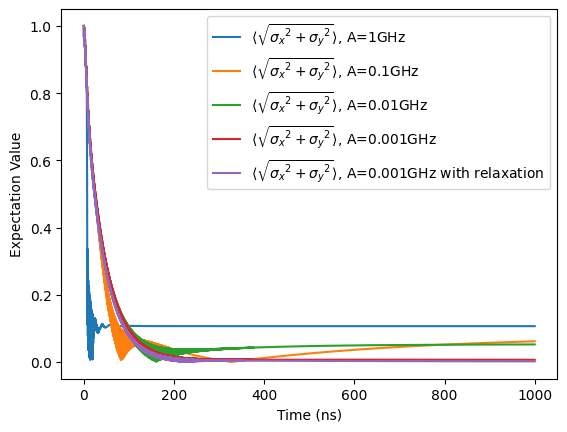

In [309]:
# Plot sqrt(X**2+Y**2)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result16.expect[0])**2 + (result16.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=1GHz')
ax.plot(tlist, np.sqrt((result17.expect[0])**2 + (result17.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.1GHz')
ax.plot(tlist, np.sqrt((result18.expect[0])**2 + (result18.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.01GHz')
ax.plot(tlist, np.sqrt((result19.expect[0])**2 + (result19.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz')
ax.plot(tlist, np.sqrt((result20.expect[0])**2 + (result20.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz with relaxation')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

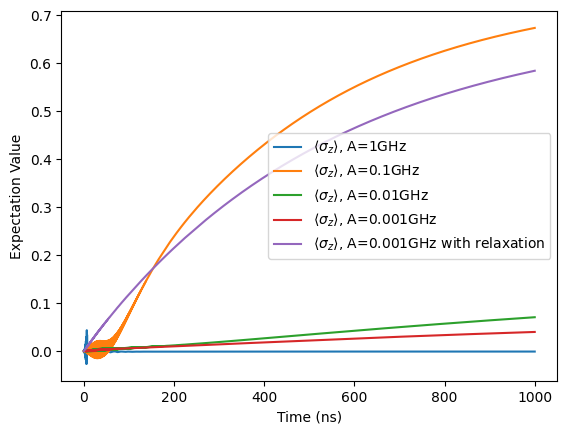

In [310]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result16.expect[2], label = r'$\langle\sigma_z\rangle$, A=1GHz')
ax.plot(tlist, result17.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.1GHz')
ax.plot(tlist, result18.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.01GHz')
ax.plot(tlist, result19.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.001GHz')
ax.plot(tlist, result20.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.001GHz with relaxation')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

A=1GHz


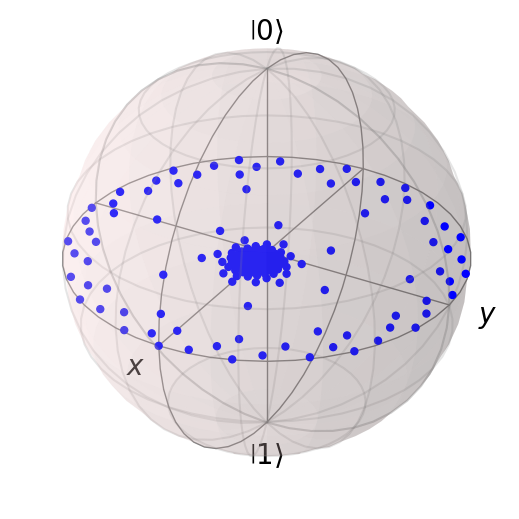

In [311]:
# Create Bloch sphere plot
print("A=1GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result16.expect, meth="s")
sphere.show()

A=0.1GHz


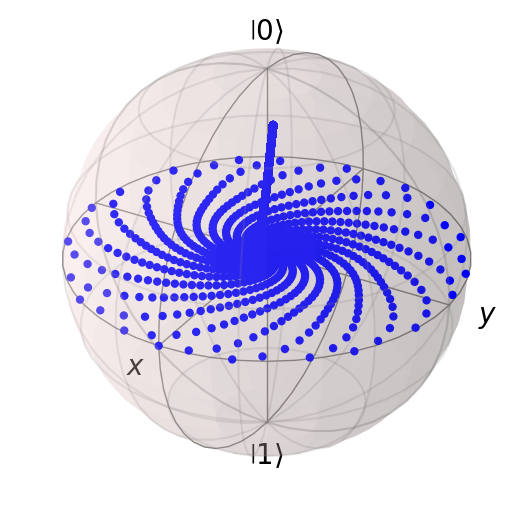

In [312]:
# Create Bloch sphere plot
print("A=0.1GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result17.expect, meth="s")
sphere.show()

A=0.01GHz


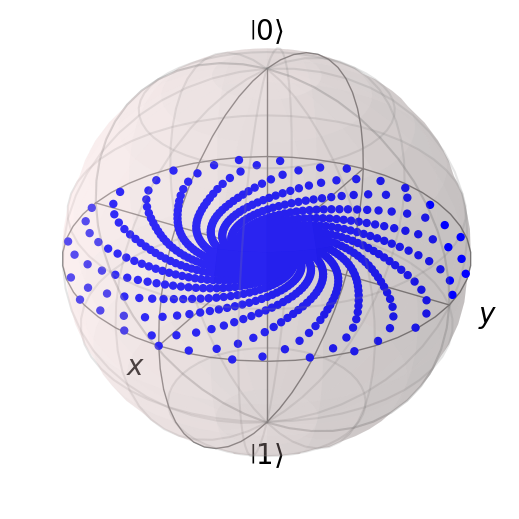

In [313]:
# Create Bloch sphere plot
print("A=0.01GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result18.expect, meth="s")
sphere.show()

A=0.001GHz


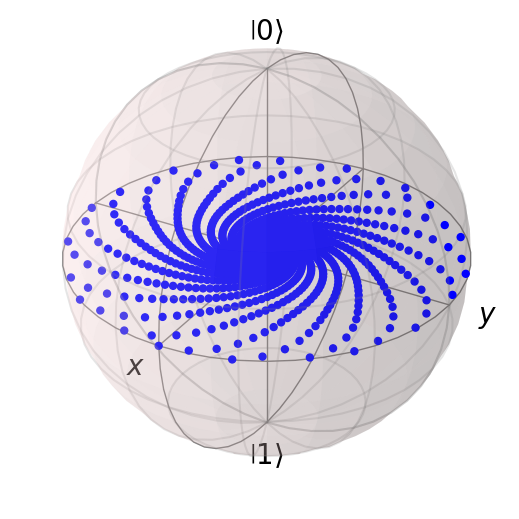

In [314]:
# Create Bloch sphere plot
print("A=0.001GHz")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result19.expect, meth="s")
sphere.show()

A=0.001GHz with relaxation


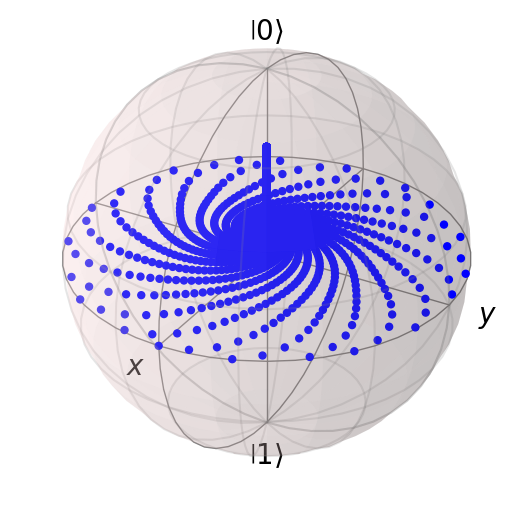

In [315]:
# Create Bloch sphere plot
print("A=0.001GHz with relaxation")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result20.expect, meth="s")
sphere.show()

Text(0, 0.5, 'Photon Number Expectation Value')

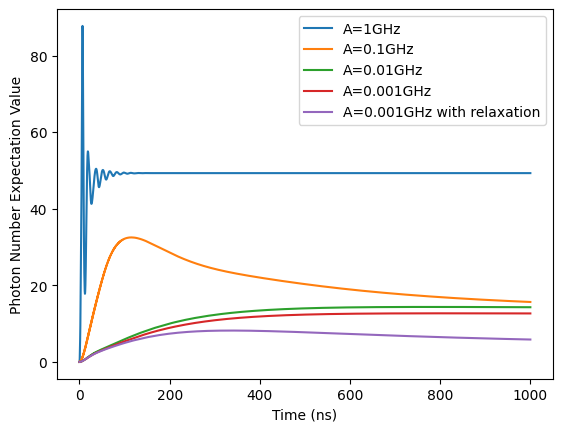

In [316]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result16.expect[7], label = 'A=1GHz')
ax.plot(tlist, result17.expect[7], label = 'A=0.1GHz')
ax.plot(tlist, result18.expect[7], label = 'A=0.01GHz')
ax.plot(tlist, result19.expect[7], label = 'A=0.001GHz')
ax.plot(tlist, result20.expect[7], label = 'A=0.001GHz with relaxation')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

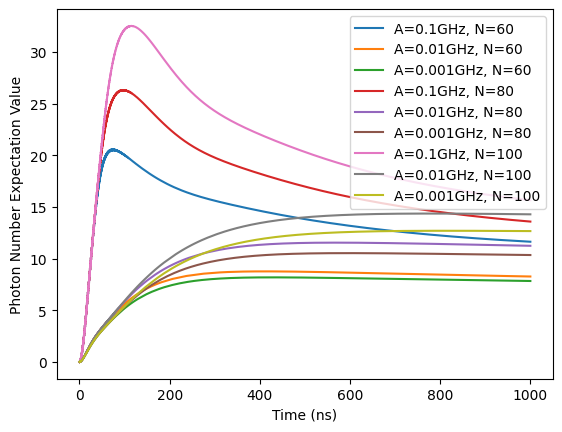

In [317]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result7.expect[7], label = 'A=0.1GHz, N=60')
ax.plot(tlist, result8.expect[7], label = 'A=0.01GHz, N=60')
ax.plot(tlist, result9.expect[7], label = 'A=0.001GHz, N=60')
ax.plot(tlist, result12.expect[7], label = 'A=0.1GHz, N=80')
ax.plot(tlist, result13.expect[7], label = 'A=0.01GHz, N=80')
ax.plot(tlist, result14.expect[7], label = 'A=0.001GHz, N=80')
ax.plot(tlist, result17.expect[7], label = 'A=0.1GHz, N=100')
ax.plot(tlist, result18.expect[7], label = 'A=0.01GHz, N=100')
ax.plot(tlist, result19.expect[7], label = 'A=0.001GHz, N=100')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

### 8) Test Simulation (Ramsey, Rotating Frame) : Determining Dimension N

Because when readout frequency is 6.999GHz, Truncation Error caused.
Let's set readout frequency 6.99GHz.

Resonator Dimension $N=60, 80, 100, 120$

Driving Amplitude $A=0.01GHz$, $A=0.001GHz$

Driving Frequency $\omega_{rd}=6.99GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$


In [318]:
# operator
N = 60

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.99   # qubit frequency in units of GHz
g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result21 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.01, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result22 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

In [319]:
# operator
N = 80

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.99   # qubit frequency in units of GHz
g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result23 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.01, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result24 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

In [320]:
# operator
N = 100

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.99   # qubit frequency in units of GHz
g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result25 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.01, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result26 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

In [321]:
# operator
N = 120

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.99   # qubit frequency in units of GHz
g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result27 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.01, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result28 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

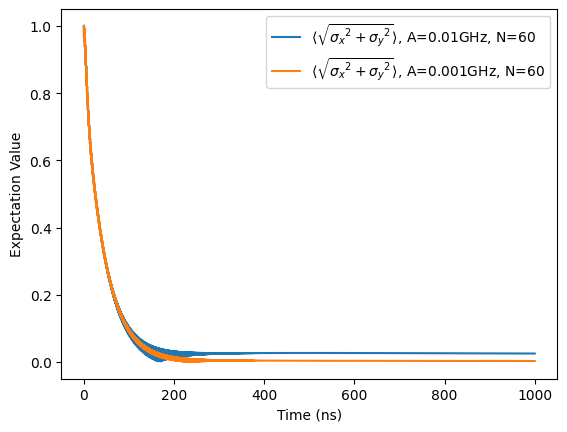

In [322]:
# Plot sqrt(X**2+Y**2) when N=60

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result21.expect[0])**2 + (result21.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.01GHz, N=60')
ax.plot(tlist, np.sqrt((result22.expect[0])**2 + (result22.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz, N=60')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

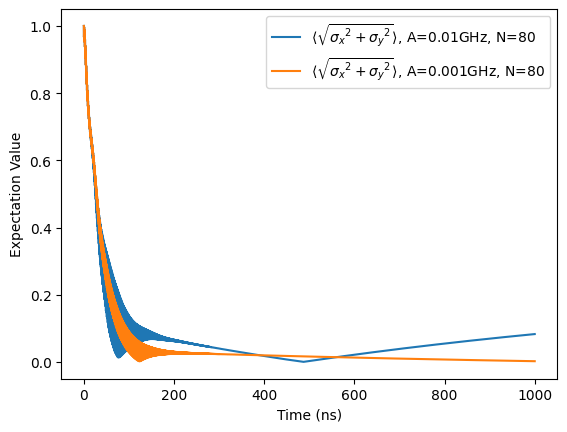

In [323]:
# Plot sqrt(X**2+Y**2) when N=80

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result23.expect[0])**2 + (result23.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.01GHz, N=80')
ax.plot(tlist, np.sqrt((result24.expect[0])**2 + (result24.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz, N=80')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

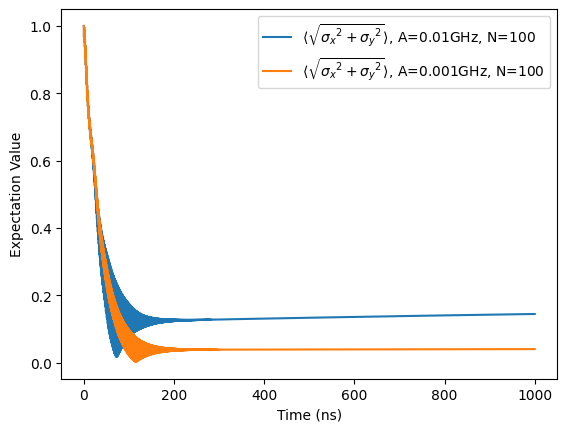

In [324]:
# Plot sqrt(X**2+Y**2) when N=100

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result25.expect[0])**2 + (result25.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.01GHz, N=100')
ax.plot(tlist, np.sqrt((result26.expect[0])**2 + (result26.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz, N=100')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

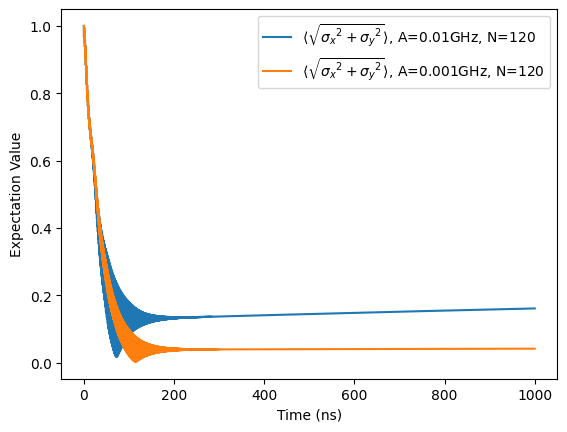

In [325]:
# Plot sqrt(X**2+Y**2) when N=120

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result27.expect[0])**2 + (result27.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.01GHz, N=120')
ax.plot(tlist, np.sqrt((result28.expect[0])**2 + (result28.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz, N=120')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

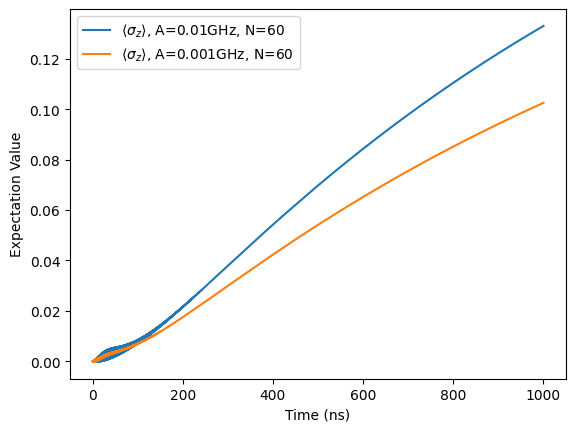

In [326]:
# Plot Z when N=60

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result21.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.01GHz, N=60')
ax.plot(tlist, result22.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.001GHz, N=60')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

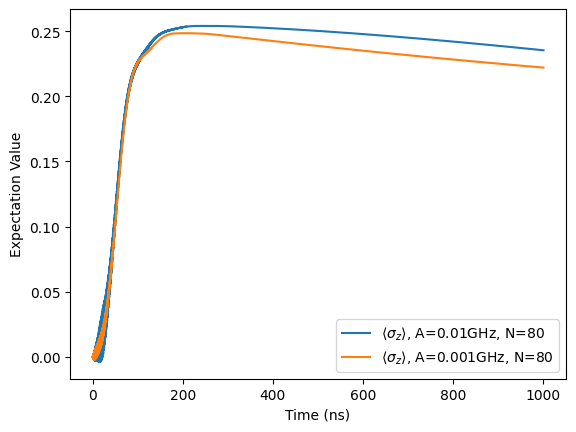

In [327]:
# Plot Z when N=80

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result23.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.01GHz, N=80')
ax.plot(tlist, result24.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.001GHz, N=80')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

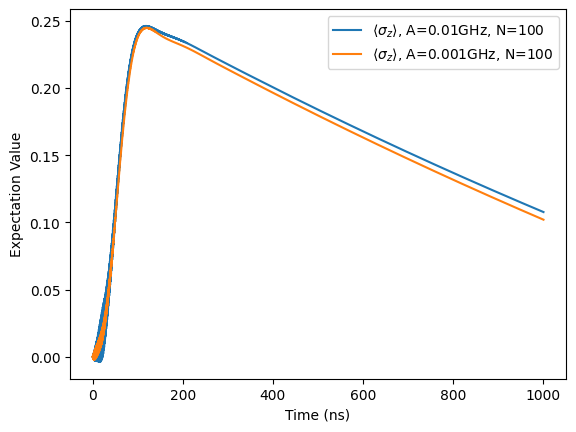

In [328]:
# Plot Z when N=100

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result25.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.01GHz, N=100')
ax.plot(tlist, result26.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.001GHz, N=100')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

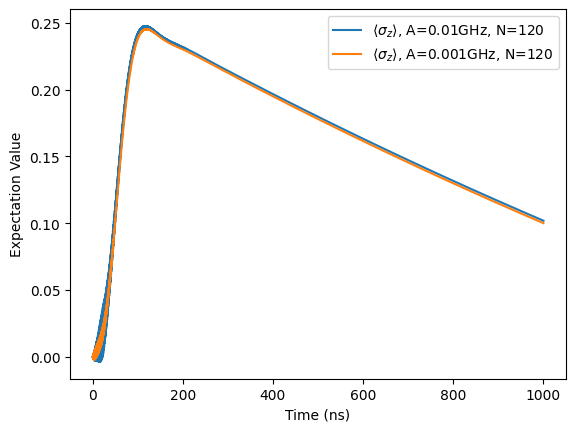

In [329]:
# Plot Z when N=120

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result27.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.01GHz, N=120')
ax.plot(tlist, result28.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.001GHz, N=120')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

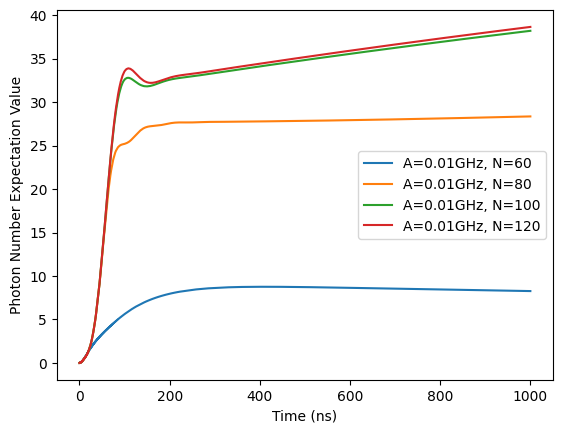

In [330]:
# Plot photon number expectation value when A=0.01GHz

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result21.expect[7], label = 'A=0.01GHz, N=60')
ax.plot(tlist, result23.expect[7], label = 'A=0.01GHz, N=80')
ax.plot(tlist, result25.expect[7], label = 'A=0.01GHz, N=100')
ax.plot(tlist, result27.expect[7], label = 'A=0.01GHz, N=120')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

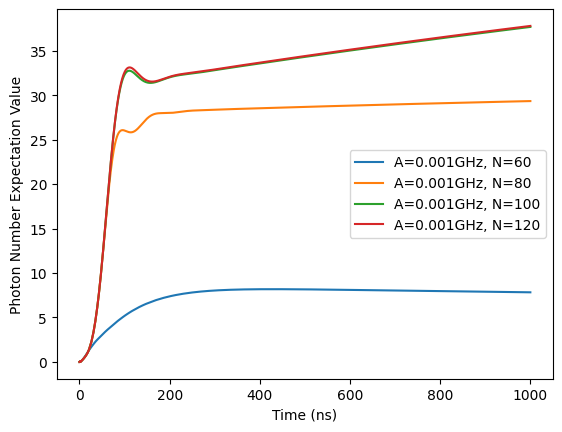

In [331]:
# Plot photon number expectation value when A=0.01GHz

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result22.expect[7], label = 'A=0.001GHz, N=60')
ax.plot(tlist, result24.expect[7], label = 'A=0.001GHz, N=80')
ax.plot(tlist, result26.expect[7], label = 'A=0.001GHz, N=100')
ax.plot(tlist, result28.expect[7], label = 'A=0.001GHz, N=120')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

### 9) Test Simulation (Ramsey, Rotating Frame) : Determining Dimension N

There might be Truncation Error when $A=1GHz$, $A=0.1GHz$

Resonator Dimension $N=100$

Driving Amplitude $A=1, 0.1, 0.01, 0.001, 0.0001, 0.00001 GHz$

Driving Frequency $\omega_{rd}=6.99GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

In [332]:
# operator
N = 100

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.99   # qubit frequency in units of GHz
g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result29 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result30 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result31 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result32 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.00001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

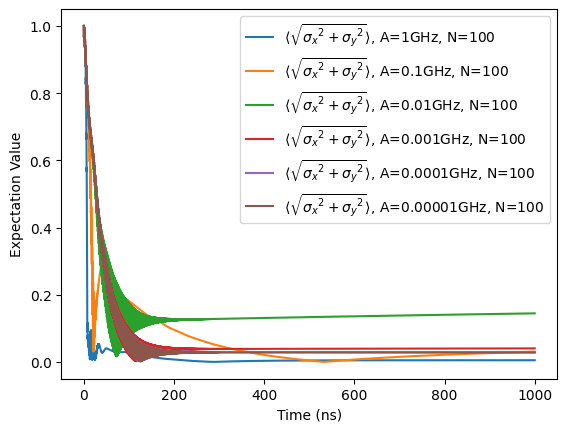

In [333]:
# Plot sqrt(X**2+Y**2) when N=100

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result29.expect[0])**2 + (result29.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=1GHz, N=100')
ax.plot(tlist, np.sqrt((result30.expect[0])**2 + (result30.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.1GHz, N=100')
ax.plot(tlist, np.sqrt((result25.expect[0])**2 + (result25.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.01GHz, N=100')
ax.plot(tlist, np.sqrt((result26.expect[0])**2 + (result26.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.001GHz, N=100')
ax.plot(tlist, np.sqrt((result31.expect[0])**2 + (result31.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.0001GHz, N=100')
ax.plot(tlist, np.sqrt((result32.expect[0])**2 + (result32.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.00001GHz, N=100')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

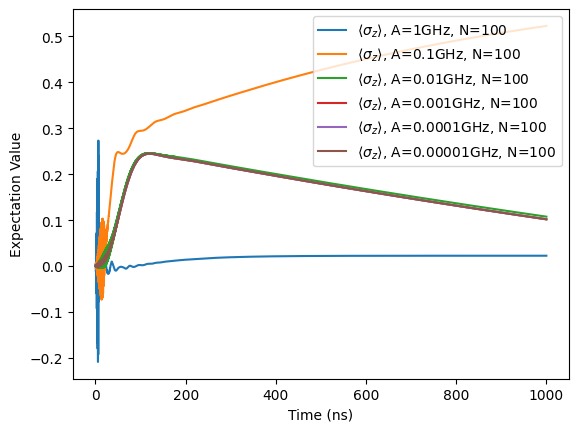

In [334]:
# Plot Z when N=100

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result29.expect[2], label = r'$\langle\sigma_z\rangle$, A=1GHz, N=100')
ax.plot(tlist, result30.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.1GHz, N=100')
ax.plot(tlist, result25.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.01GHz, N=100')
ax.plot(tlist, result26.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.001GHz, N=100')
ax.plot(tlist, result31.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.0001GHz, N=100')
ax.plot(tlist, result32.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.00001GHz, N=100')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

A=1GHz, N=100


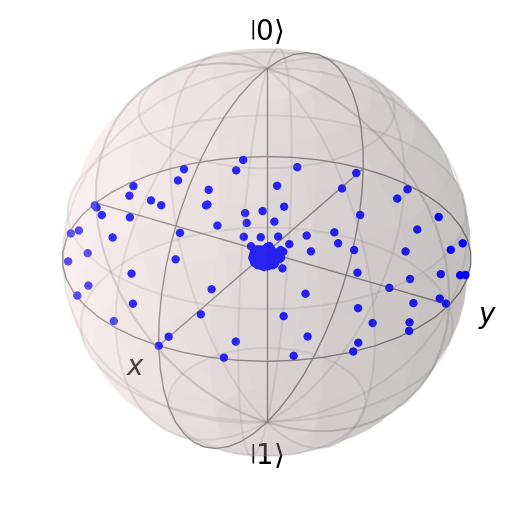

In [335]:
# Create Bloch sphere plot
print("A=1GHz, N=100")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result29.expect, meth="s")
sphere.show()

A=0.1GHz, N=100


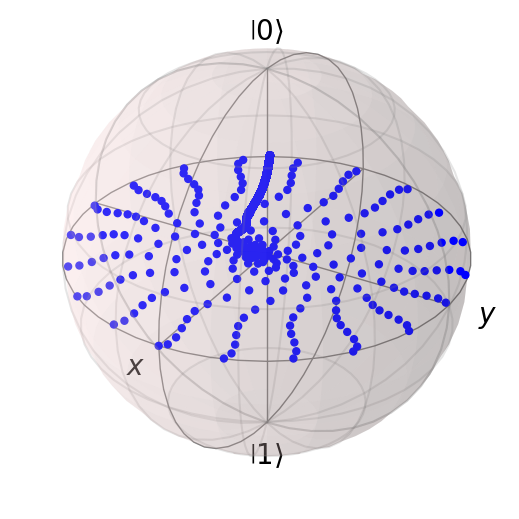

In [336]:
# Create Bloch sphere plot
print("A=0.1GHz, N=100")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result30.expect, meth="s")
sphere.show()

A=0.01GHz, N=100


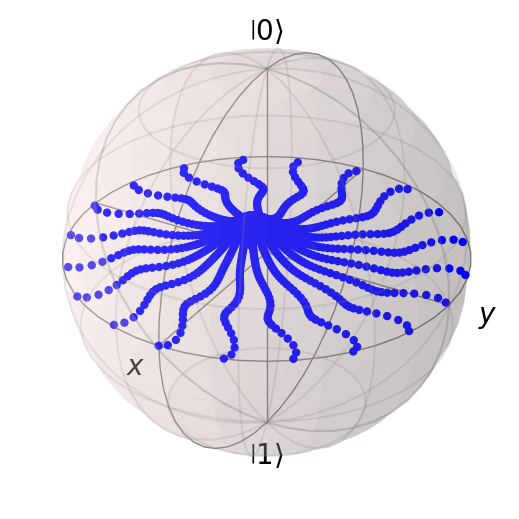

In [337]:
# Create Bloch sphere plot
print("A=0.01GHz, N=100")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result25.expect, meth="s")
sphere.show()

A=0.001GHz, N=100


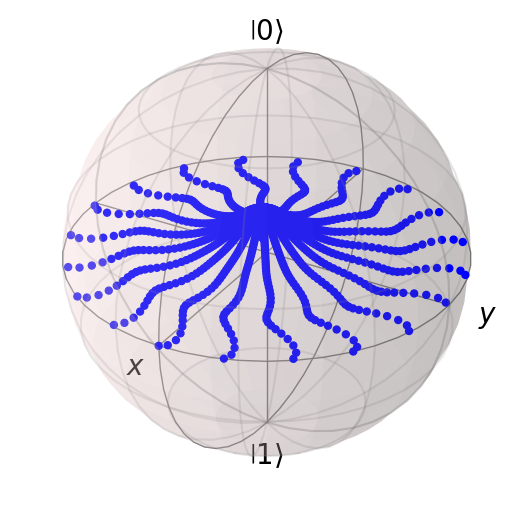

In [338]:
# Create Bloch sphere plot
print("A=0.001GHz, N=100")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result26.expect, meth="s")
sphere.show()

A=0.0001GHz, N=100


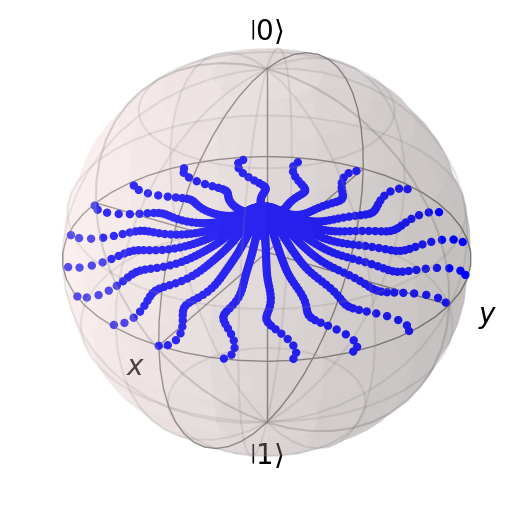

In [339]:
# Create Bloch sphere plot
print("A=0.0001GHz, N=100")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result31.expect, meth="s")
sphere.show()

A=0.00001GHz, N=100


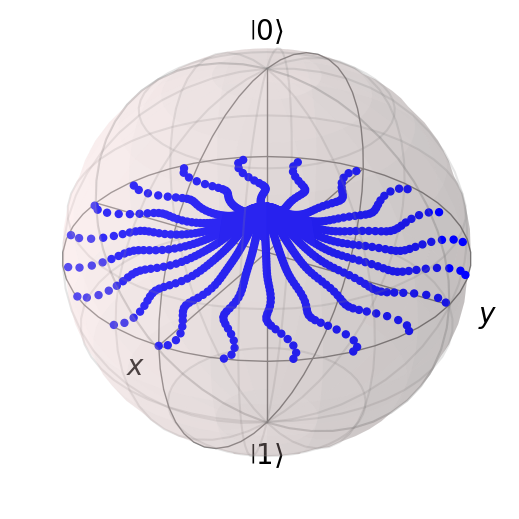

In [340]:
# Create Bloch sphere plot
print("A=0.00001GHz, N=100")
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result32.expect, meth="s")
sphere.show()

Text(0, 0.5, 'Photon Number Expectation Value')

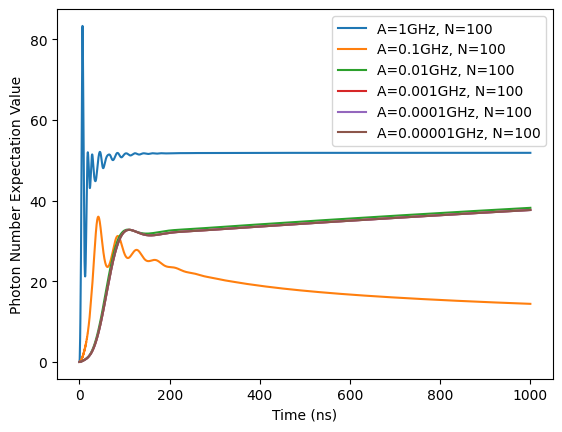

In [341]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result29.expect[7], label = 'A=1GHz, N=100')
ax.plot(tlist, result30.expect[7], label = 'A=0.1GHz, N=100')
ax.plot(tlist, result25.expect[7], label = 'A=0.01GHz, N=100')
ax.plot(tlist, result26.expect[7], label = 'A=0.001GHz, N=100')
ax.plot(tlist, result31.expect[7], label = 'A=0.0001GHz, N=100')
ax.plot(tlist, result32.expect[7], label = 'A=0.00001GHz, N=100')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

### 10) Spectroscopy of Qubit Off-diagonal Term

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Expectation Value')

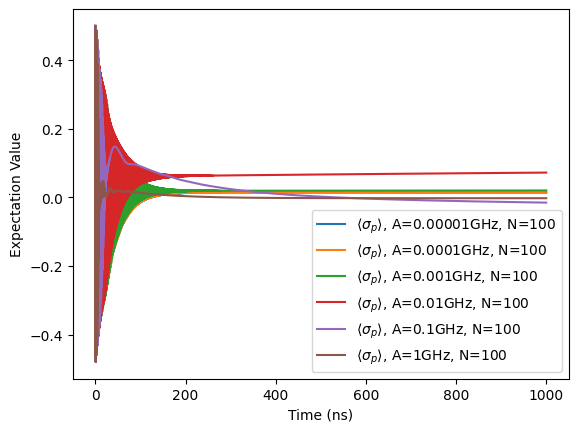

In [342]:
plus_5 = result32.expect[3]
plus_4 = result31.expect[3]
plus_3 = result26.expect[3]
plus_2 = result25.expect[3]
plus_1 = result30.expect[3]
plus_0 = result29.expect[3]

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, plus_5, label = r'$\langle\sigma_p\rangle$, A=0.00001GHz, N=100')
ax.plot(tlist, plus_4, label = r'$\langle\sigma_p\rangle$, A=0.0001GHz, N=100')
ax.plot(tlist, plus_3, label = r'$\langle\sigma_p\rangle$, A=0.001GHz, N=100')
ax.plot(tlist, plus_2, label = r'$\langle\sigma_p\rangle$, A=0.01GHz, N=100')
ax.plot(tlist, plus_1, label = r'$\langle\sigma_p\rangle$, A=0.1GHz, N=100')
ax.plot(tlist, plus_0, label = r'$\langle\sigma_p\rangle$, A=1GHz, N=100')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'FT Absolute Value (linear scale)')

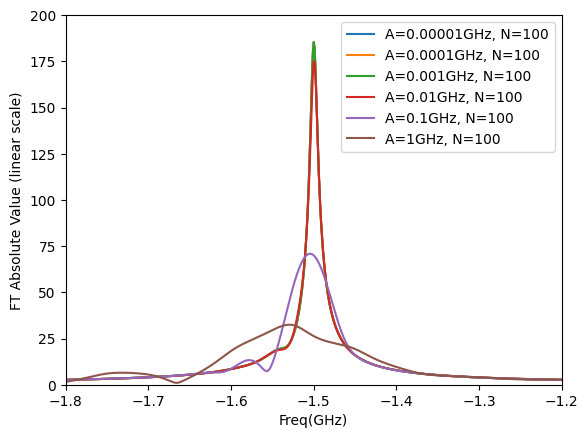

In [346]:
plus_5_fft = np.fft.fftshift(np.fft.fft(plus_5))
plus_5_freq = np.fft.fftshift(np.fft.fftfreq(len(plus_5), d=tlist[1]-tlist[0]))

plus_4_fft = np.fft.fftshift(np.fft.fft(plus_4))
plus_4_freq = np.fft.fftshift(np.fft.fftfreq(len(plus_4), d=tlist[1]-tlist[0]))

plus_3_fft = np.fft.fftshift(np.fft.fft(plus_3))
plus_3_freq = np.fft.fftshift(np.fft.fftfreq(len(plus_3), d=tlist[1]-tlist[0]))

plus_2_fft = np.fft.fftshift(np.fft.fft(plus_2))
plus_2_freq = np.fft.fftshift(np.fft.fftfreq(len(plus_2), d=tlist[1]-tlist[0]))

plus_1_fft = np.fft.fftshift(np.fft.fft(plus_1))
plus_1_freq = np.fft.fftshift(np.fft.fftfreq(len(plus_1), d=tlist[1]-tlist[0]))

plus_0_fft = np.fft.fftshift(np.fft.fft(plus_0))
plus_0_freq = np.fft.fftshift(np.fft.fftfreq(len(plus_0), d=tlist[1]-tlist[0]))


plt.figure()

plt.plot(plus_5_freq, np.abs(plus_5_fft), label='A=0.00001GHz, N=100')
plt.plot(plus_4_freq, np.abs(plus_4_fft), label='A=0.0001GHz, N=100')
plt.plot(plus_3_freq, np.abs(plus_3_fft), label='A=0.001GHz, N=100')
plt.plot(plus_2_freq, np.abs(plus_2_fft), label='A=0.01GHz, N=100')
plt.plot(plus_1_freq, np.abs(plus_1_fft), label='A=0.1GHz, N=100')
plt.plot(plus_0_freq, np.abs(plus_0_fft), label='A=1GHz, N=100')

plt.legend()
plt.xlim(-1.8,-1.2)
plt.ylim(0,200)
plt.xlabel('Freq(GHz)')
plt.ylabel('FT Absolute Value (linear scale)')

# 10. Measurement Induced Dephasing Dynamical Decoupling

### 1) Hamiltonian Setting

In [352]:
# operator
N = 100

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.99   # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

gamma_1 = 2 * np.pi * 0.0002  # qubit longitudinal relaxation rate
gamma_2 = 2 * np.pi * 0.00015 # qubit transverse relaxation rate

In [353]:
sz = sigmaz()
sx = sigmax()
sy = sigmay()

sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)

In [354]:
sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [355]:
H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

### 2) X $\pi$-Pulse derived Measurement Induced Dephasing Decoupling without Qubit Natural Relaxation

Resonator Dimension $100$

$π$-Pulse Number $N = 0, 2, 4, 6, 8, 10, 12, 20$

Driving Amplitude $A=0.0001GHz$

Driving Frequency $\omega_{rd}=6.99GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

Evolution Time 0 ~ 100ns

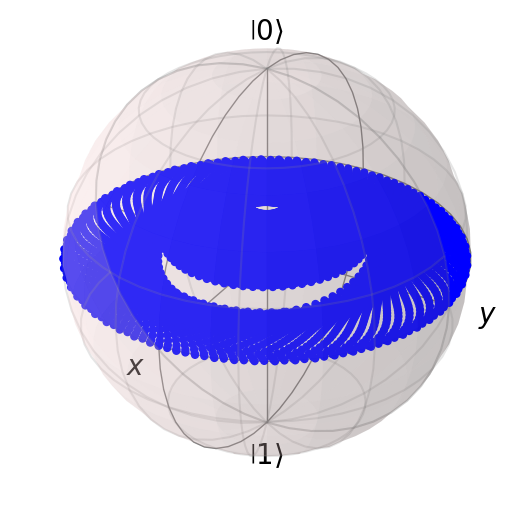

In [375]:
T = 100
tlist = np.linspace(0, T, 10000)

resultt = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 2, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(resultt.expect, meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

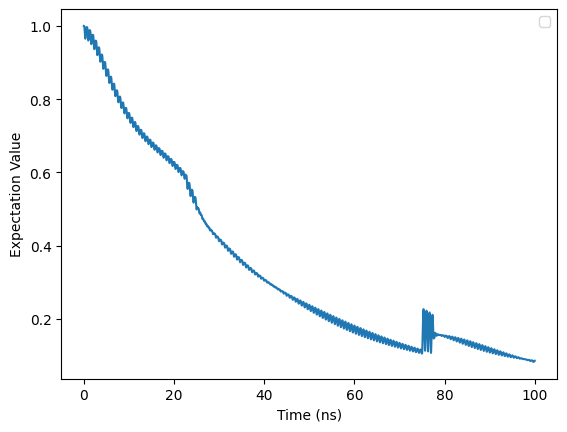

In [372]:
fig, ax = plt.subplots(1, 1)

ax.plot(tlist, np.sqrt((resultt.expect[0])**2 + (resultt.expect[1])**2))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

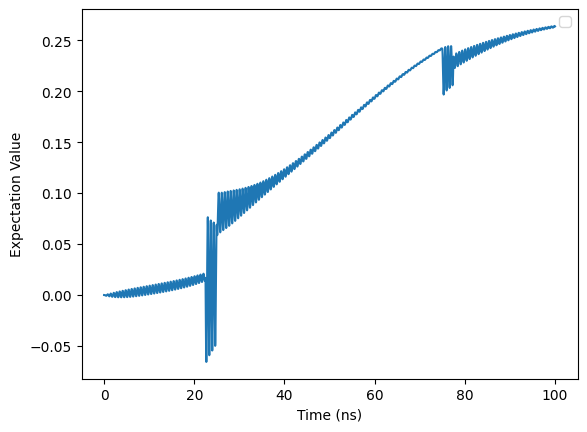

In [373]:
fig, ax = plt.subplots(1, 1)

ax.plot(tlist, resultt.expect[2])

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [356]:
T = 100
tlist = np.linspace(0, T, 10000)

result33 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result34 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 2, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result35 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 4, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result36 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 6, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result37 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 8, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result38 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 10, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result39 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 12, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result40 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 20, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

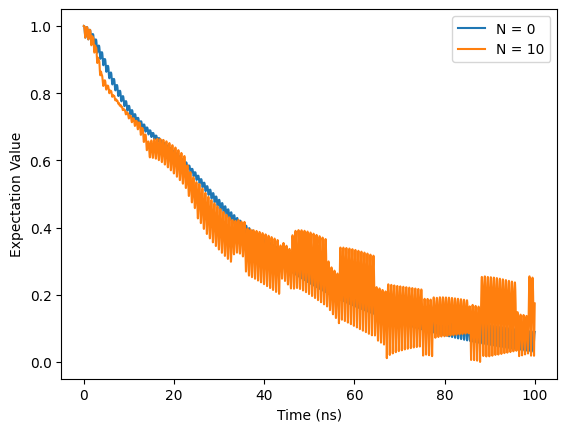

In [369]:
# Plot sqrt(X**2+Y**2) for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, np.sqrt((result33.expect[0])**2 + (result33.expect[1])**2), label = 'N = 0')
#ax.plot(tlist, np.sqrt((result34.expect[0])**2 + (result34.expect[1])**2), label = 'N = 2')
#ax.plot(tlist, np.sqrt((result35.expect[0])**2 + (result35.expect[1])**2), label = 'N = 4')
#ax.plot(tlist, np.sqrt((result36.expect[0])**2 + (result36.expect[1])**2), label = 'N = 6')
#ax.plot(tlist, np.sqrt((result37.expect[0])**2 + (result37.expect[1])**2), label = 'N = 8')
ax.plot(tlist, np.sqrt((result38.expect[0])**2 + (result38.expect[1])**2), label = 'N = 10')
#ax.plot(tlist, np.sqrt((result39.expect[0])**2 + (result39.expect[1])**2), label = 'N = 12')
#ax.plot(tlist, np.sqrt((result40.expect[0])**2 + (result40.expect[1])**2), label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

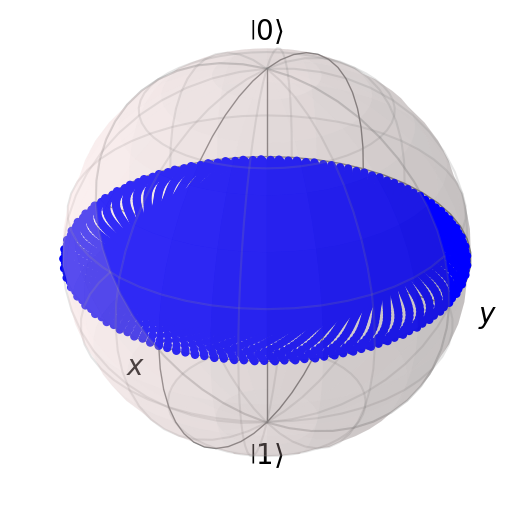

In [358]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result33.expect, meth="s")
sphere.show()

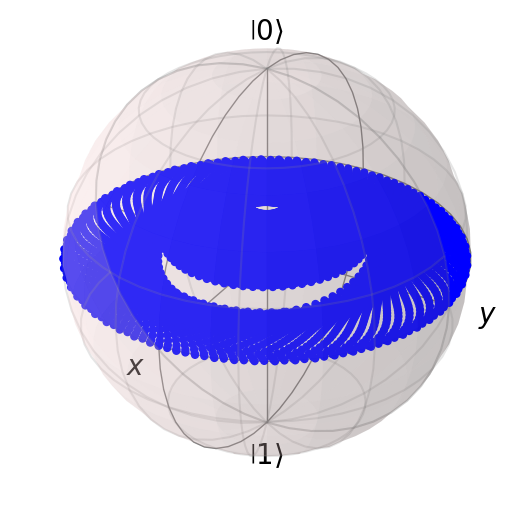

In [359]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result34.expect, meth="s")
sphere.show()

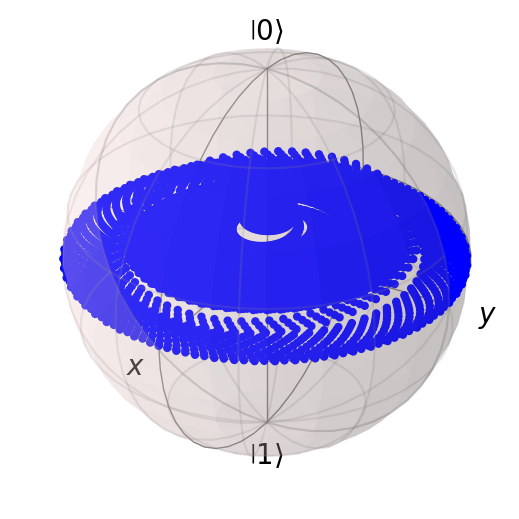

In [360]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result35.expect, meth="s")
sphere.show()

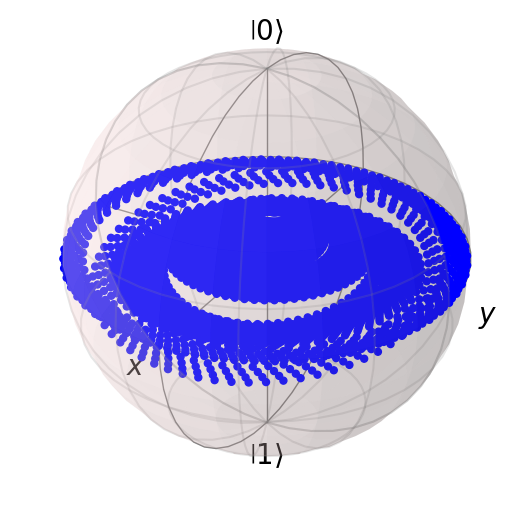

In [361]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result36.expect, meth="s")
sphere.show()

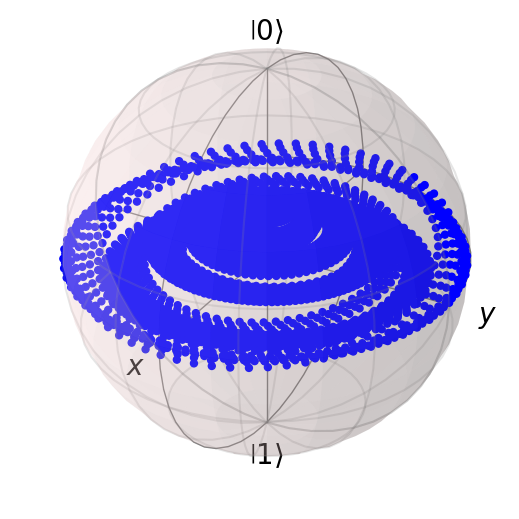

In [362]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result37.expect, meth="s")
sphere.show()

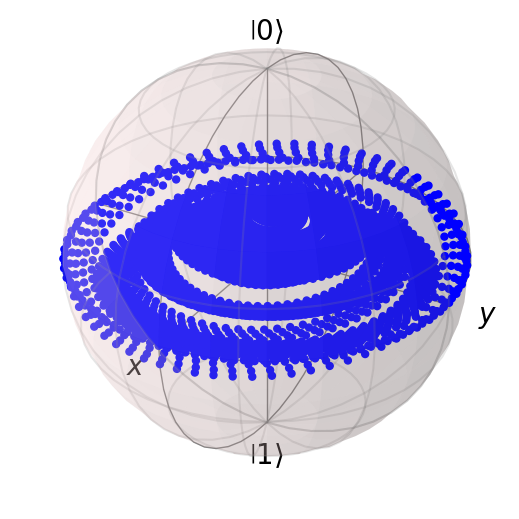

In [363]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result38.expect, meth="s")
sphere.show()

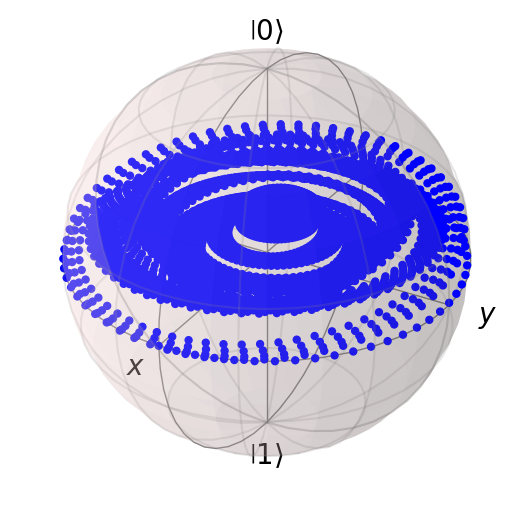

In [364]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result39.expect, meth="s")
sphere.show()

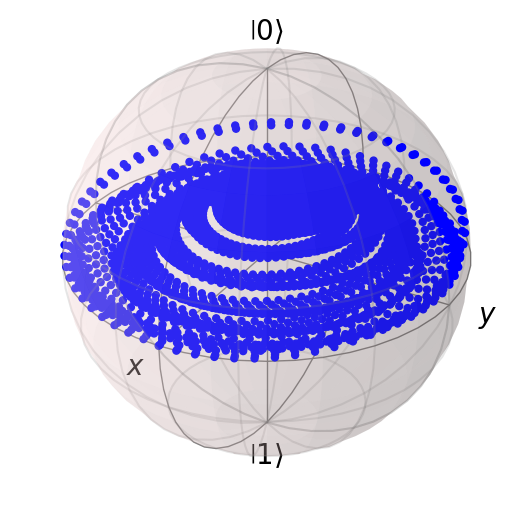

In [365]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result40.expect, meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

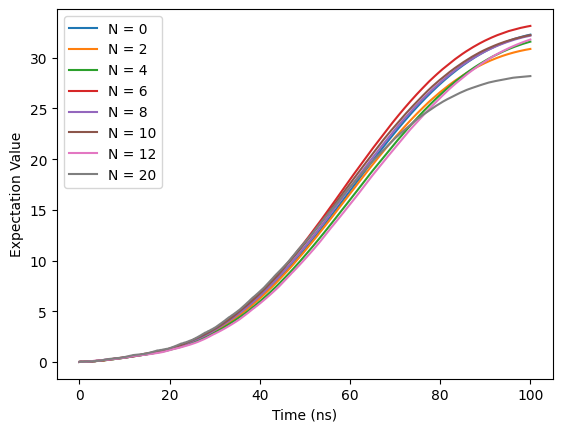

In [366]:
# Plot photon number for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, result33.expect[7], label = 'N = 0')
ax.plot(tlist, result34.expect[7], label = 'N = 2')
ax.plot(tlist, result35.expect[7], label = 'N = 4')
ax.plot(tlist, result36.expect[7], label = 'N = 6')
ax.plot(tlist, result37.expect[7], label = 'N = 8')
ax.plot(tlist, result38.expect[7], label = 'N = 10')
ax.plot(tlist, result39.expect[7], label = 'N = 12')
ax.plot(tlist, result40.expect[7], label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

### 3) X $\pi$-Pulse derived Measurement Induced Dephasing Decoupling without Qubit Natural Relaxation

Resonator Dimension $100$

$π$-Pulse Number $N = 0, 2, 4, 6, 8, 10, 12, 20$

Driving Amplitude $A=0.0001GHz$

Driving Frequency $\omega_{rd}=6.99GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

Evolution Time 0 ~ 200ns

In [ ]:
T = 200
tlist = np.linspace(0, T, 10000)

result41 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result42 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 2, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result43 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 4, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result44 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 6, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result45 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 8, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result46 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 10, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result47 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 12, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result48 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 20, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

In [ ]:
# Plot sqrt(X**2+Y**2) for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, np.sqrt((result41.expect[0])**2 + (result41.expect[1])**2), label = 'N = 0')
ax.plot(tlist, np.sqrt((result42.expect[0])**2 + (result42.expect[1])**2), label = 'N = 2')
ax.plot(tlist, np.sqrt((result43.expect[0])**2 + (result43.expect[1])**2), label = 'N = 4')
ax.plot(tlist, np.sqrt((result44.expect[0])**2 + (result44.expect[1])**2), label = 'N = 6')
ax.plot(tlist, np.sqrt((result45.expect[0])**2 + (result45.expect[1])**2), label = 'N = 8')
ax.plot(tlist, np.sqrt((result46.expect[0])**2 + (result46.expect[1])**2), label = 'N = 10')
ax.plot(tlist, np.sqrt((result47.expect[0])**2 + (result47.expect[1])**2), label = 'N = 12')
ax.plot(tlist, np.sqrt((result48.expect[0])**2 + (result48.expect[1])**2), label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [ ]:
# Plot photon number for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, result41.expect[7], label = 'N = 0')
ax.plot(tlist, result42.expect[7], label = 'N = 2')
ax.plot(tlist, result43.expect[7], label = 'N = 4')
ax.plot(tlist, result44.expect[7], label = 'N = 6')
ax.plot(tlist, result45.expect[7], label = 'N = 8')
ax.plot(tlist, result46.expect[7], label = 'N = 10')
ax.plot(tlist, result47.expect[7], label = 'N = 12')
ax.plot(tlist, result48.expect[7], label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

### 4) X $\pi$-Pulse derived Measurement Induced Dephasing Decoupling without Qubit Natural Relaxation

Resonator Dimension $100$

$π$-Pulse Number $N = 0, 2, 4, 6, 8, 10, 12, 20$

Driving Amplitude $A=0.0001GHz$

Driving Frequency $\omega_{rd}=6.99GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

Evolution Time 0 ~ 300ns

In [ ]:
T = 300
tlist = np.linspace(0, T, 10000)

result49 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result50 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 2, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result51 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 4, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result52 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 6, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result53 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 8, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result54 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 10, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result55 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 12, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result56 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 20, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

In [ ]:
# Plot sqrt(X**2+Y**2) for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, np.sqrt((result49.expect[0])**2 + (result49.expect[1])**2), label = 'N = 0')
ax.plot(tlist, np.sqrt((result50.expect[0])**2 + (result50.expect[1])**2), label = 'N = 2')
ax.plot(tlist, np.sqrt((result51.expect[0])**2 + (result51.expect[1])**2), label = 'N = 4')
ax.plot(tlist, np.sqrt((result52.expect[0])**2 + (result52.expect[1])**2), label = 'N = 6')
ax.plot(tlist, np.sqrt((result53.expect[0])**2 + (result53.expect[1])**2), label = 'N = 8')
ax.plot(tlist, np.sqrt((result54.expect[0])**2 + (result54.expect[1])**2), label = 'N = 10')
ax.plot(tlist, np.sqrt((result55.expect[0])**2 + (result55.expect[1])**2), label = 'N = 12')
ax.plot(tlist, np.sqrt((result56.expect[0])**2 + (result56.expect[1])**2), label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [ ]:
# Plot photon number for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, result49.expect[7], label = 'N = 0')
ax.plot(tlist, result50.expect[7], label = 'N = 2')
ax.plot(tlist, result51.expect[7], label = 'N = 4')
ax.plot(tlist, result52.expect[7], label = 'N = 6')
ax.plot(tlist, result53.expect[7], label = 'N = 8')
ax.plot(tlist, result54.expect[7], label = 'N = 10')
ax.plot(tlist, result55.expect[7], label = 'N = 12')
ax.plot(tlist, result56.expect[7], label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

### 4) X $\pi$-Pulse derived Measurement Induced Dephasing Decoupling without Qubit Natural Relaxation

Resonator Dimension $100$

$π$-Pulse Number $N = 0, 2, 4, 6, 8, 10, 12, 20$

Driving Amplitude $A=0.0001GHz$

Driving Frequency $\omega_{rd}=6.99GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

Evolution Time 0 ~ 400ns

In [ ]:
T = 400
tlist = np.linspace(0, T, 10000)

result57 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result58 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 2, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result59 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 4, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result60 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 6, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result61 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 8, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result62 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 10, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result63 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 12, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result64 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 20, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

In [ ]:
# Plot sqrt(X**2+Y**2) for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, np.sqrt((result57.expect[0])**2 + (result57.expect[1])**2), label = 'N = 0')
ax.plot(tlist, np.sqrt((result58.expect[0])**2 + (result58.expect[1])**2), label = 'N = 2')
ax.plot(tlist, np.sqrt((result59.expect[0])**2 + (result59.expect[1])**2), label = 'N = 4')
ax.plot(tlist, np.sqrt((result60.expect[0])**2 + (result60.expect[1])**2), label = 'N = 6')
ax.plot(tlist, np.sqrt((result61.expect[0])**2 + (result61.expect[1])**2), label = 'N = 8')
ax.plot(tlist, np.sqrt((result62.expect[0])**2 + (result62.expect[1])**2), label = 'N = 10')
ax.plot(tlist, np.sqrt((result63.expect[0])**2 + (result63.expect[1])**2), label = 'N = 12')
ax.plot(tlist, np.sqrt((result64.expect[0])**2 + (result64.expect[1])**2), label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [ ]:
# Plot photon number for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, result49.expect[7], label = 'N = 0')
ax.plot(tlist, result50.expect[7], label = 'N = 2')
ax.plot(tlist, result51.expect[7], label = 'N = 4')
ax.plot(tlist, result52.expect[7], label = 'N = 6')
ax.plot(tlist, result53.expect[7], label = 'N = 8')
ax.plot(tlist, result54.expect[7], label = 'N = 10')
ax.plot(tlist, result55.expect[7], label = 'N = 12')
ax.plot(tlist, result56.expect[7], label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

### 10) Measurement Induced Dephasing Decoupling? (N = 0,2,4,10,20,30,40)

start at superposition state

In [ ]:
off_0 = []

for k in range(250, 1050, 50):
  tlist = np.linspace(0, k, 10000)

  result20 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': k+2.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.5, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  x = result20.expect[0]
  y = result20.expect[1]

  off_0.append(np.sqrt((x[-1])**2 + (y[-1])**2))

  print(k)


off_0 = np.array(off_0)

250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [ ]:
off_2 = []

for k in range(250, 1050, 50):
  tlist = np.linspace(0, k, 10000)

  result20 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': k+2.5, 'N': 2, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.5, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  x = result20.expect[0]
  y = result20.expect[1]

  off_2.append(np.sqrt((x[-1])**2 + (y[-1])**2))

  print(k)


off_2 = np.array(off_2)

250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [ ]:
off_4 = []

for k in range(250, 1050, 50):
  tlist = np.linspace(0, k, 10000)

  result20 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': k+2.5, 'N': 4, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.5, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  x = result20.expect[0]
  y = result20.expect[1]

  off_4.append(np.sqrt((x[-1])**2 + (y[-1])**2))

  print(k)


off_4 = np.array(off_4)

250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [ ]:
off_10 = []

for k in range(250, 1050, 50):
  tlist = np.linspace(0, k, 10000)

  result20 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': k+2.5, 'N': 10, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.5, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  x = result20.expect[0]
  y = result20.expect[1]

  off_10.append(np.sqrt((x[-1])**2 + (y[-1])**2))

  print(k)


off_10 = np.array(off_10)

250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [ ]:
off_20 = []

for k in range(250, 1050, 50):
  tlist = np.linspace(0, k, 10000)

  result20 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': k+2.5, 'N': 20, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.5, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  x = result20.expect[0]
  y = result20.expect[1]

  off_20.append(np.sqrt((x[-1])**2 + (y[-1])**2))

  print(k)


off_20 = np.array(off_20)

250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [ ]:
off_30 = []

for k in range(250, 1050, 50):
  tlist = np.linspace(0, k, 10000)

  result20 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': k+2.5, 'N': 30, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.5, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  x = result20.expect[0]
  y = result20.expect[1]

  off_30.append(np.sqrt((x[-1])**2 + (y[-1])**2))

  print(k)


off_30 = np.array(off_30)

250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [ ]:
off_40 = []

for k in range(250, 1050, 50):
  tlist = np.linspace(0, k, 10000)

  result20 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': k+2.5, 'N': 40, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.5, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  x = result20.expect[0]
  y = result20.expect[1]

  off_40.append(np.sqrt((x[-1])**2 + (y[-1])**2))

  print(k)


off_40 = np.array(off_40)

250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


Text(0, 0.5, 'Expectation Value')

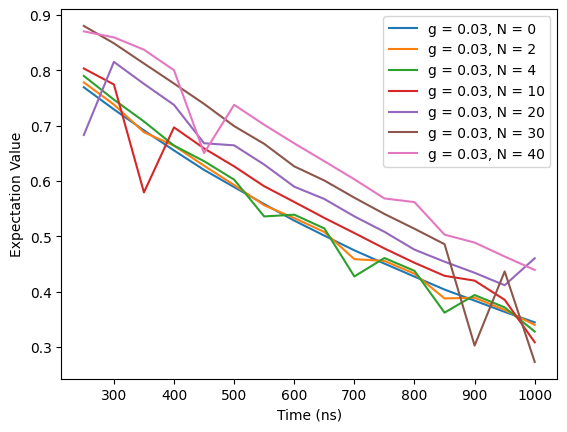

In [ ]:
# Plot off-diagonal term
tau_list = np.array([k for k in range(250, 1050, 50)])

fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, off_0, label = 'g = 0.03, N = 0')
ax.plot(tau_list, off_2, label = 'g = 0.03, N = 2')
ax.plot(tau_list, off_4, label = 'g = 0.03, N = 4')
ax.plot(tau_list, off_10, label = 'g = 0.03, N = 10')
ax.plot(tau_list, off_20, label = 'g = 0.03, N = 20')
ax.plot(tau_list, off_30, label = 'g = 0.03, N = 30')
ax.plot(tau_list, off_40, label = 'g = 0.03, N = 40')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')